# Assignment 4: Sampling and Model Interpretability
-----------------------------------

**Dr. Dave Wanik - OPIM 5512: Data Science Using Python - University of Connecticut**

-----------------------------------


**Nikhila Bommareddy**

Put your sampling and interpretability skills to the test!

You will build a classification model using a sampling technique of your choice (oversampling, undersampling or SMOTE - I'm not testing how good your model is for this assignment, just that you know how to interpret the model!). We will use CA housing since you have some experience with this from tree-based models. You can use any classification model we have covered in class (DTC, RFC, GBC or logistic regression.)

# Rubric
* (10 points) Count values of each class before and after your sampling to confirm your understanding of how the sampling worked, and write a bullet of why your results make sense.

Then you will:
* (40 points) Print the top 3 features (using permutation importance with 15 repeats) in a box plot.
* (40 points) Create the partial dependence plots for the top 3 features (you may opt to use the num_grid_points argument). Customize the plots so that the Y axis is consistent on each of the five plots and remember that the Y axis is showing the change in predicted probability.
* (10 points) Write five meaningful bullets about what you see in the plots and tables. Does anything surprise you?
  * **Optional:** Potential with issues concerning correlated predictors (read here for a cool way on how to address this: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html)?

# Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from numpy import where
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler

# classification error metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# permutation testing
from sklearn.inspection import permutation_importance

!pip install pulp # for partial dependence plots!
!pip install pycebox
from pycebox.ice import ice, ice_plot

# avoid display of warnings
import warnings

df = pd.read_csv('/content/sample_data/california_housing_train.csv')
df.head()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 74.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycebox: filename=pycebox-0.0.1-py3-none-any.whl size=3625 sha256=af2bc554376227f36d5cd85111e25c4c220bc988bcca20fd0b2b5c62163d9879
  Stored in directory: /root/.cache/pip/wheels/af/57/4b/0d7bdd5b5ee35d225b01da15c62ed0ec0af10073f24a4a03ce
Successfully built pycebox


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


And we will recode the target variable to a classification problem.

In [2]:
# by using 75th percentile, we will have nice imbalanced data!
df['median_house_value'] = np.where(df['median_house_value'] > np.percentile(df['median_house_value'], q=75), 1, 0)
df['median_house_value'].value_counts()

0    12753
1     4247
Name: median_house_value, dtype: int64

# Split into X and y

In [3]:
X = df.drop('median_house_value', axis =1)
X
y = df['median_house_value']
y

0        0
1        0
2        0
3        0
4        0
        ..
16995    0
16996    0
16997    0
16998    0
16999    0
Name: median_house_value, Length: 17000, dtype: int64

# Split data into train and test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3099352)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape) # looks good!

(13600, 8) (3400, 8)
(13600,) (3400,)


## Using counters to understand the distribution

The training data has 10185 0's and 3415 1's - clearly imbalanced data

In [5]:
# Training data
Counter(y_train)

Counter({0: 10185, 1: 3415})

In [6]:
# Test data
Counter(y_test)

Counter({0: 2568, 1: 832})

# Scaling

Performing min/max scaling before doing sampling

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Sampling

Let us go ahead with SMOTE sampling technique
SMOTE works with numeric data. Here, in our dataset all our values are numeric - we have checked that using info()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [9]:
# Let us go ahead with SMOTE sampling technique using K-nearest neighbour

oversample = SMOTE(k_neighbors=9)
# We should perform sampling only on train information
X_res, y_res = oversample.fit_resample(X_train, y_train)
Counter(y_res)

Counter({0: 10185, 1: 10185})

## Now the training dataset has equal distribution of 0's and 1's
  * With the help of SMOTE sampling technique, we were able to remove the class imbalance.

  * It is important to perform such so as to avoid having biased predictions.

# Model and Metrics
Let us build the model using gradient boosting technique

In [10]:
# use any model you want - fit on train, predict on test!
# you should print confusion matrix and classification report
#  for train and test partitions

In [11]:
GBC = GradientBoostingClassifier()
GBC = GBC.fit(X_train, y_train)

train_preds_GBC = GBC.predict(X_train)
test_preds_GBC = GBC.predict(X_test)

## Confusion Matrix

In [12]:
# train confusion matrix
confusion_matrix(y_train, train_preds_GBC)

array([[9864,  321],
       [ 885, 2530]])

In [13]:
# test confusion matrix
confusion_matrix(y_test, test_preds_GBC)

array([[2475,   93],
       [ 239,  593]])

In [14]:
# extract TP, TN, FP, FN
tn, fp, fn, tp = confusion_matrix(y_test, test_preds_GBC).ravel()
(tn, fp, fn, tp)

(2475, 93, 239, 593)

## Classification Report

In [15]:
# train report
trainReport_GBC = classification_report(y_train, train_preds_GBC)
print(trainReport_GBC)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     10185
           1       0.89      0.74      0.81      3415

    accuracy                           0.91     13600
   macro avg       0.90      0.85      0.87     13600
weighted avg       0.91      0.91      0.91     13600



In [16]:
# test report
testReport_GBC = classification_report(y_test, test_preds_GBC)
print(testReport_GBC)

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2568
           1       0.86      0.71      0.78       832

    accuracy                           0.90      3400
   macro avg       0.89      0.84      0.86      3400
weighted avg       0.90      0.90      0.90      3400



# Interpretability

## Permutation Importance

In [17]:
# permutation importance is on X_test

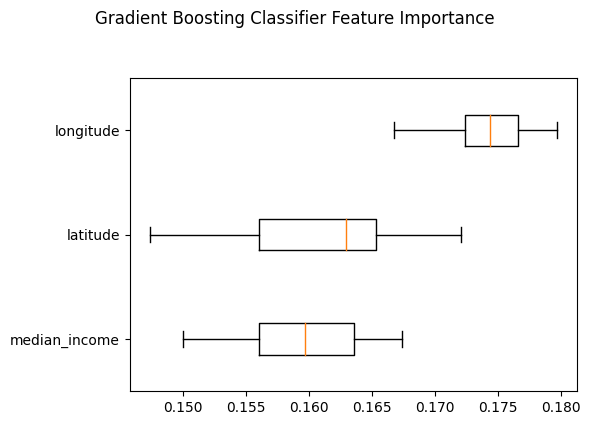

In [25]:
clf = GBC # just update the title!

result = permutation_importance(clf, X_test, y_test, n_repeats=15,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()[-3:]
# added the [-3:] , to show only the top 3 features in the box plot.
# if we need all , use perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X.columns[perm_sorted_idx])
fig.suptitle('Gradient Boosting Classifier Feature Importance', y=1.05)
fig.tight_layout()
plt.show()

## Partial Dependence

In [19]:
# partial dependence is on X_train

In [20]:
# For generating partial dependency plots, we need to create a new dataframe with X_train
train_X_df = pd.DataFrame(X_train, columns=X.columns)
train_X_df.head()
train_X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13600 entries, 0 to 13599
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           13600 non-null  float64
 1   latitude            13600 non-null  float64
 2   housing_median_age  13600 non-null  float64
 3   total_rooms         13600 non-null  float64
 4   total_bedrooms      13600 non-null  float64
 5   population          13600 non-null  float64
 6   households          13600 non-null  float64
 7   median_income       13600 non-null  float64
dtypes: float64(8)
memory usage: 850.1 KB


In [21]:
def plot_ice_grid(dict_of_ice_dfs, data_df, features, ax_ylabel='', nrows=1,
                  ncols=3, figsize=(12, 3), sharex=False, sharey=True,
                  num_grid_points = 10, # DW added this on 4/27/2022!
                  subplots_kws={}, rug_kws={'color':'k'}, **ice_plot_kws):
    """A function that plots ICE plots for different features in a grid."""
    fig, axes = plt.subplots(nrows=nrows,
                             ncols=ncols,
                             figsize=figsize,
                             sharex=sharex,
                             sharey=sharey,
                             **subplots_kws)
    # for each feature plot the ice curves and add a rug at the bottom of the
    # subplot
    for f, ax in zip(features, axes.flatten()):
        ice_plot(dict_of_ice_dfs[f], ax=ax, **ice_plot_kws)
        # add the rug
        sns.distplot(data_df[f] , ax=ax, hist=False, kde=False,
                     rug=True, rug_kws=rug_kws)
        ax.set_title('feature = ' + f)
        ax.set_ylabel(ax_ylabel)
        sns.despine()

    # get rid of blank plots
    for i in range(len(features), nrows*ncols):
        axes.flatten()[i].axis('off')

    return fig

In [22]:
# features = X.columns[perm_sorted_idx]
# features

In [23]:
# features = train_X_df.columns
# features

<ipython-input-21-cbb4af9a70c6>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_df[f] , ax=ax, hist=False, kde=False,
<ipython-input-21-cbb4af9a70c6>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_df[f] , ax=ax, hist=False, kde=False,
<ipython-input-21-cbb4af9a70c6>:17: UserWarnin

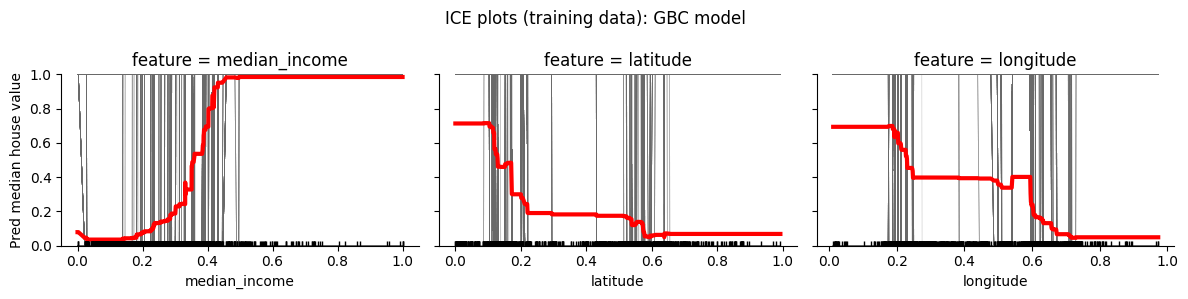

In [24]:
features = X.columns[perm_sorted_idx]
# create dict of ICE data for grid of ICE plots
train_ice_dfs = {feat: ice(data=train_X_df[0:2000], column=feat, predict=GBC.predict)
                 for feat in features}

plot_ice_grid(train_ice_dfs, train_X_df[0:2000], features,
                    ax_ylabel='Pred median house value', alpha=0.3, plot_pdp=True,
                    pdp_kwargs={'c': 'red', 'linewidth': 3},
                    linewidth=0.5, c='dimgray')
plt.ylim([0,1])
plt.suptitle('ICE plots (training data): GBC model')
plt.subplots_adjust(top=0.89)
plt.tight_layout()
warnings.filterwarnings("ignore")

# Conclusions

* From the classification report , we can notice an accuracy of 90%. This accuracy is consistent among the training and test data.

* Without Sampling of the information, the model would not have been qualified enough to predict the minority data points within the test dataset.

* The partial dependency plots show that there is a non-linear relationship between the highest predicted variables and the predicted house value.

* With the increase in median_income, the house value increases exponentially, but after a threshold, the house values are constant. (or predicted above the median house value, that is 1)

* The house value is also determined by the latitude and longitude values.

However, this data is not 100% as per generated, as for the plots we ahve taken only a sample of 2000 records.